# 示例：轴承故障诊断

In [9]:
from torch import nn

from rulframework.data.dataset.FaultLabelGenerator import FaultLabelGenerator
from rulframework.data.feature.RMSFeatureExtractor import RMSFeatureExtractor
from rulframework.data.raw.XJTUDataLoader import XJTUDataLoader
from rulframework.entity.Bearing import BearingFault
from rulframework.model.PytorchModel import PytorchModel
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.model.cnn.CNN import CNN
from rulframework.util.Plotter import Plotter

# 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [10]:
data_loader = XJTUDataLoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = RMSFeatureExtractor(data_loader.continuum)
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, data_loader.continuum)

DEBUG - 17:10:04 >> 
<<<< 数据集位置：D:\data\dataset\XJTU-SY_Bearing_Datasets >>>>
>> 已成功登记以下数据项：
  Bearing1_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
  Bearing1_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
  Bearing1_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
  Bearing1_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
  Bearing1_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
  Bearing2_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
  Bearing2_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
  Bearing2_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
  Bearing2_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
  Bearing2_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
  Bearing3_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40Hz10kN\Bearing3_1
  Bearing3_2，位置: D:\data\dataset\XJTU-S

# 获取原始数据、特征数据、阶段数据

In [11]:
bearing = data_loader.get_bearing("Bearing1_3", 'Horizontal Vibration')
bearing.feature_data = feature_extractor.extract(bearing.raw_data)
stage_calculator.calculate_state(bearing)

# 生成训练数据

In [12]:
generator = FaultLabelGenerator(2048, list(BearingFault.__members__.values()), is_onehot=False)
dataset = generator.generate(bearing)

# 通过其他轴承增加训练数据

In [13]:
for bearing_name in ['Bearing1_1', 'Bearing1_4', 'Bearing2_1', 'Bearing1_2', 'Bearing2_3']:
    print(f'正在使用{bearing_name}构造训练数据')
    bearing_train = data_loader.get_bearing(bearing_name, 'Horizontal Vibration')
    bearing_train.feature_data = feature_extractor.extract(bearing_train.raw_data)
    stage_calculator.calculate_state(bearing_train)
    another_dataset = generator.generate(bearing_train)
    dataset.append(another_dataset)

正在使用Bearing1_1构造训练数据
正在使用Bearing1_4构造训练数据
正在使用Bearing2_1构造训练数据
正在使用Bearing1_2构造训练数据
正在使用Bearing2_3构造训练数据


# 划分训练集与测试集

In [14]:
train_set, test_set = dataset.split(0.7)

# 定义模型并训练

INFO - 17:10:21 >> 
  当前使用设备：cuda
  模型参数类型：torch.float32
DEBUG - 17:10:23 >> Epoch 1/10, Loss: 1.2890306737
DEBUG - 17:10:24 >> Epoch 2/10, Loss: 1.1567167147
DEBUG - 17:10:26 >> Epoch 3/10, Loss: 1.1351960306
DEBUG - 17:10:28 >> Epoch 4/10, Loss: 1.1172178418
DEBUG - 17:10:29 >> Epoch 5/10, Loss: 1.0500225116
DEBUG - 17:10:31 >> Epoch 6/10, Loss: 1.0174494060
DEBUG - 17:10:33 >> Epoch 7/10, Loss: 1.0118478627
DEBUG - 17:10:34 >> Epoch 8/10, Loss: 1.0033818831
DEBUG - 17:10:36 >> Epoch 9/10, Loss: 1.0009976990
DEBUG - 17:10:38 >> Epoch 10/10, Loss: 1.0036729544


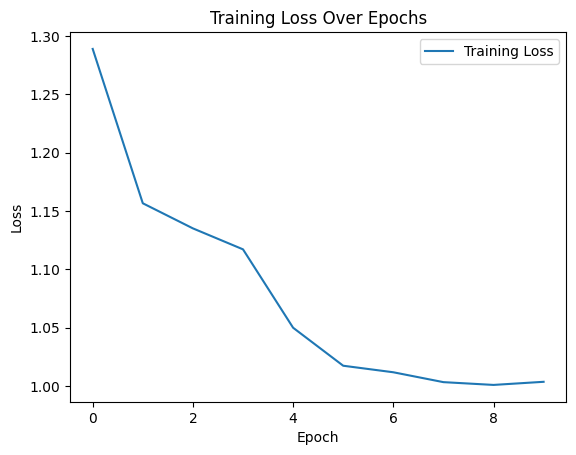

In [15]:
model = PytorchModel(CNN(), criterion=nn.CrossEntropyLoss())

model.end2end_train(train_set, 10, weight_decay=0.01)
Plotter.loss(model)

# 预测

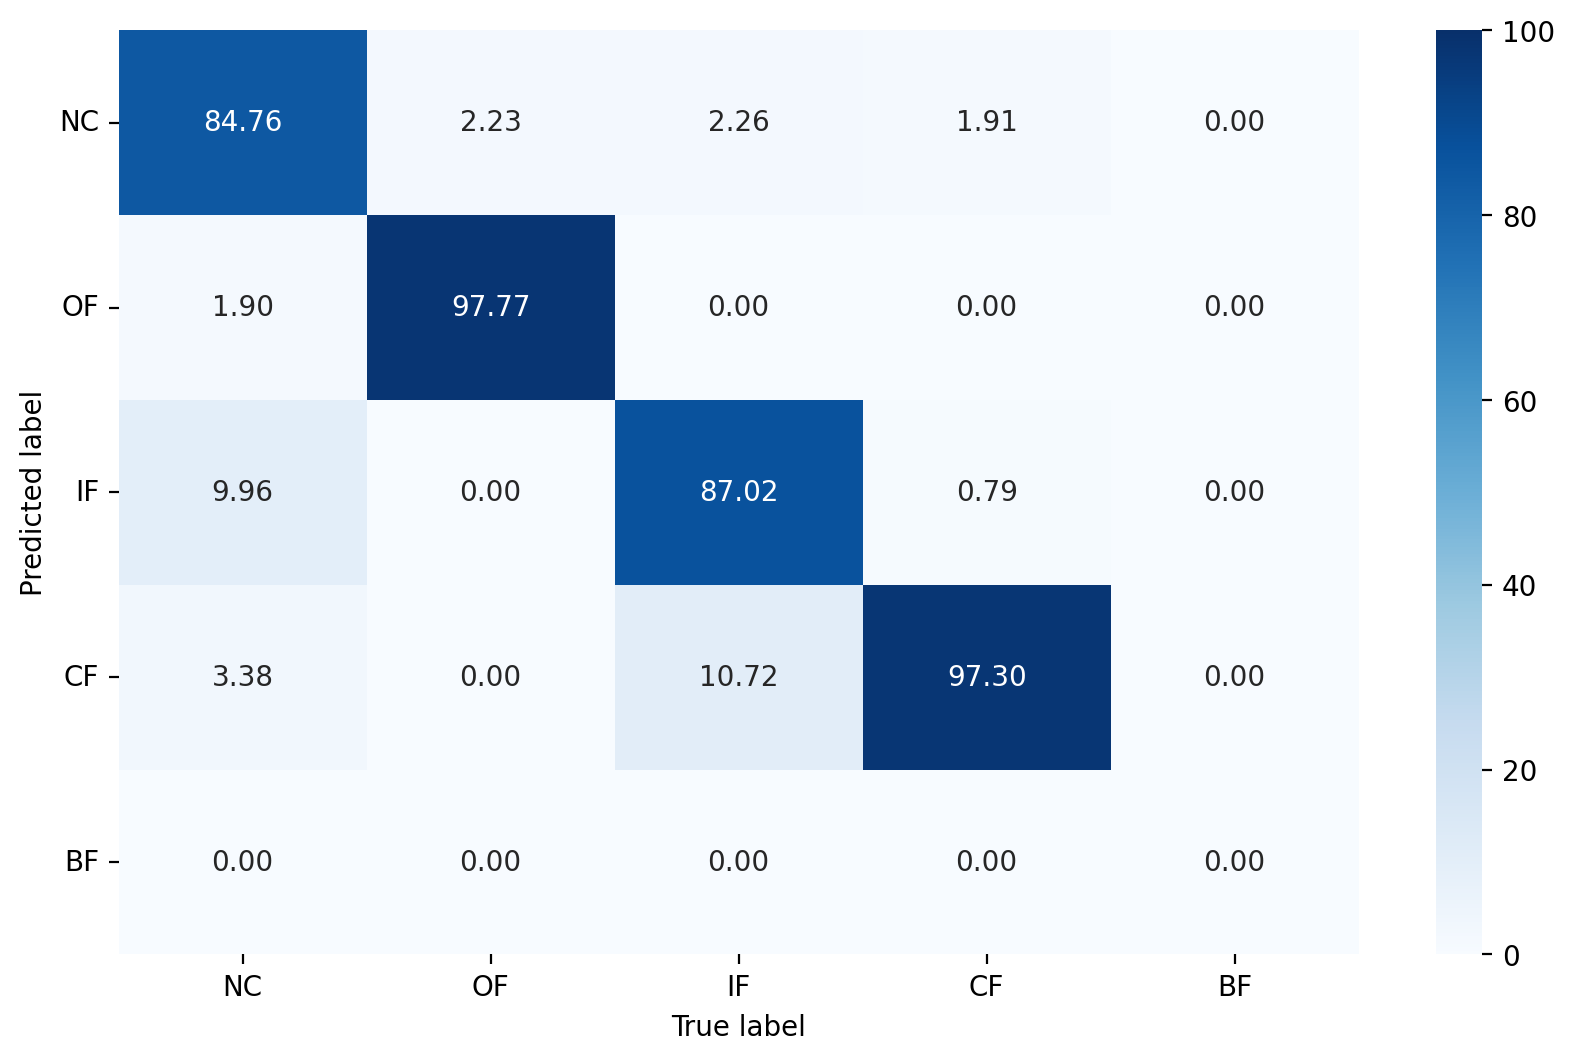

In [16]:
result = model.end2end_predict(test_set)
Plotter.fault_prediction_heatmap(test_set, result)